# Training 

This notebook includes an example training loop for a one stage model.

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from datetime import datetime

from model.one_model.one_stage_models import ResNet50OneStage, ResNet18OneStage
from data.dataset import CheXpertDataset

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## Datasets

In [3]:
# Define parameter dictionary
params_transform = {
    "resize": (256, 256),
    "degree_range": (-15, 15),
    "translate": (0.1, 0.2),
    "scale": (0.2, 1.0),
    "ratio": (0.75, 1.3333333333333333),
    "gaussian_blur_kernel": 3,
    "contrast": (0.75, 1.25),
    "saturation": (0.75, 1.25),
    "brightness": (0.75, 1.25),
}

transform = transforms.Compose(
    [
        transforms.Resize(params_transform["resize"]),
        transforms.ToTensor(),
        transforms.RandomRotation(params_transform["degree_range"]),
        transforms.RandomAffine(
            degrees=params_transform["degree_range"],
            translate=params_transform["translate"],
        ),
        transforms.RandomResizedCrop(
            size=params_transform["resize"],
            scale=params_transform["scale"],
            ratio=params_transform["ratio"],
        ),
        transforms.GaussianBlur(kernel_size=params_transform["gaussian_blur_kernel"]),
        transforms.ColorJitter(
            brightness=params_transform["brightness"],
            contrast=params_transform["contrast"],
            saturation=params_transform["saturation"],
        ),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(params_transform["resize"]),
        transforms.ToTensor(),
    ]
)

targets = {
            # "sex": 1,
            # "age": 2,
            # "frontal/lateral": 3,
            # "ap/pa": 4,
            # "no_finding": 5,
            #"enlarged_cardiomediastinum": 6,
             "cardiomegaly": 7,
            # "lung_opacity": 8,
            # "lung_lesion": 9,
            "edema": 10,
            "consolidation": 11,
            # "pneumonia": 12,
            "atelectasis": 13,
            # "pneumothorax": 14,
            "pleural_effusion": 15,
            # "pleural_other": 16,
            # "fracture": 17,
            # "support_devices": 18,
            # "ap/pa map": 22,
        }

train_dataset = CheXpertDataset(
    csv_file="./data/splitted/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)
val_dataset = CheXpertDataset(
    csv_file="./data/test.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=val_transform,
)

Train dataset size: 11171
Valid dataset size: 234
Example
labels: [0. 1. 0. 1. 0.]
torch.Size([1, 256, 256])


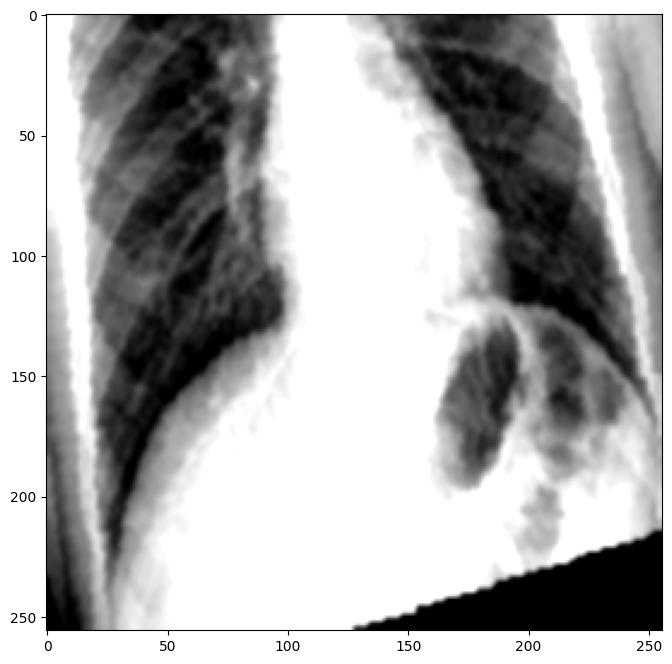

In [4]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

print("Example")
img, labels = train_dataset[0]
print(f"labels: {labels}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

## Define model

In [ ]:
params = {
    "train_transfrom": params_transform,
    "lr": 0.0001,
    "lr_decay_gamma": 0.9,
    "lr_decay_period": 2,
    "save_epoch": 5,
    "batch_size": 128,
    "num_epochs": 50,
    "label_smoothing": 0.2,
    "input_channels": 1,
    "optimizer": "adam",
    "num_workers": 0,
    "loss_fn": "multilabel_focal_loss", # "BCEWithLogitsLoss", "weighted_bce_loss"
    "pos_weights_train": train_dataset.pos_weights,
    "pos_weights_val": val_dataset.pos_weights, 
    "gamma" : 2,
    "alpha": 0.25,
    "reduction": "mean",
    # For multilabel: MultiLabelSoftMarginLoss
    "metrics": ["accuracy", "f1_score", "precision", "recall", "confusion_matrix", "auc", "auroc", "multilabel_accuracy", "multilabel_auprc", "multilabel_precision_recall_curve", "mcc"],
    "confidence_threshold": 0.5,
}

model = ResNet18OneStage(params=params, targets=targets, input_channels=params['input_channels'])

c:\Users\flobr\Documents\Code\Master\Semester_3\ADLM\Personalized_ML\model\one_model\one_stage_models.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else:
c:\Users\flobr\Documents\Code\Master\Semester_3\ADLM\Personalized_ML\model\one_model\one_stage_models.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else:


## Training

In [9]:
"""
Train the model.
"""

task = "first_stage_ap_pa"

dirname = os.getcwd()
path = os.path.join(dirname, "logs", f"{model.name}_{task}")
if not os.path.exists(path):
    os.makedirs(path)
    num_of_runs = 0
else:
    num_of_runs = len(os.listdir(path))
path = os.path.join(
    path, f"run_{num_of_runs:03d}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
)
os.makedirs(path)

model.train(train_dataset=train_dataset, val_dataset=val_dataset, path=path, log_wandb=False)

Device used cuda


Validation Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s, val_loss=0.168218]


Val pleural_effusion multilabel_accuracy: 0.0683760717511177
Val pleural_effusion mcc: 0.10554075241088867


Validation Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.86it/s, val_loss=0.176251]


Val pleural_effusion multilabel_accuracy: 0.07264957576990128
Val pleural_effusion mcc: 0.12841492891311646


Validation Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.88it/s, val_loss=0.179672]


Val pleural_effusion multilabel_accuracy: 0.0683760717511177
Val pleural_effusion mcc: 0.1111682802438736


Validation Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.66it/s, val_loss=0.180799]


Val pleural_effusion multilabel_accuracy: 0.07264957576990128
Val pleural_effusion mcc: 0.17784483730793


Training Epoch 5/50:  13%|███████████████▉                                                                                                         | 12/91 [00:12<01:19,  1.01s/it, train_loss=0.074149]


KeyboardInterrupt: 

In [ ]:
print(model)

ResNet18OneStage(
  (loss_fn): BCEWithLogitsLoss()
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-